In [1]:
%load_ext autoreload
%autoreload

Load the LLM

In [2]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_community.llms.mlx_pipeline import MLXPipeline
from langchain_community.chat_models.mlx import ChatMLX
from langchain.callbacks.tracers import ConsoleCallbackHandler
from langchain.globals import set_verbose
from langchain.globals import set_debug

#set_debug(True)
#set_verbose(True)

print('Loading model...')
# Load model from huggingface, using the MLX framework to take advantage of Apple Silicon
llm = MLXPipeline.from_model_id(
    #"mlx-community/Meta-Llama-3.1-8B-Instruct-8bit",
    #"mlx-community/Meta-Llama-3.1-8B-Instruct-bf16",
    "mlx-community/Qwen2.5-32B-Instruct-4bit", # Let's try using a larger model, see if that improves results
    #"mlx-community/Llama-3.2-3B-Instruct-8bit",
    pipeline_kwargs={"max_tokens": 2048, "temp": 0.2, "repetition_penalty":1.2},
)

# Setup verbose mode: https://stackoverflow.com/a/77629872/10914628
model = ChatMLX(llm=llm, verbose=True)#.with_config({'callbacks': [ConsoleCallbackHandler()]})
print('Model loaded.')


Loading model...


/Users/frieder/Documents/GitHub/procedural-stories/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 187804.66it/s]


Model loaded.


Load the ontology

In [3]:
from owlready2 import *

onto = get_ontology('file://story_ontology3.rdf').load()

In [4]:
# Verify that there are no instances in the ontology (start with a clean ontology containg only the T-Box)

with onto:
    instances = list(Thing.instances())
    
    if len(instances) > 0:
        for thing in instances:
            print(thing)
        raise ValueError('Ontology already contains individuals')
    
    print('OK')

OK


In [5]:
from urllib.parse import quote, unquote

def encode_entity_name(name: str) -> str:
    return quote(name.lower())

def decode_entity_name(encoded_name: str) -> str:
    return unquote(encoded_name)

In [6]:
from Levenshtein import distance

def find_levenshtein_match(string: str, entity_list: list, threshold: int = 5):
    """Find a match amongst a list of entities from the ontology, in case the LLM made slight typos !"""
    minimum = threshold
    closest_entity = None
    for entity in entity_list:
        dist = distance(string, entity.hasName)
        if dist < minimum:
            minimum = dist
            closest_entity = entity
    return closest_entity

Define the setting of the story

In [7]:
#setting = "Normandie viking du 9e siècle"
setting = "post-apocalypse zombie mondiale, 1 an après le début de l'épidémie"
language = "french"

# 1. Generate the outline of the story world

In [8]:
OUTLINE_TEXT_PROMPT = """
You are the master writer tasked with creating a vibrant world specifically made to host a text adventure game for a player.
Write a few paragraphs describing the world of the story following the given narrative setting:

{{ setting }}

Your text should be quite short, concise and descriptive.
Your staff will use this text as the story world bible, they will write the characters, locations and specific events.
You should direct them as precisely as possible to create as coherent and unified world for the player to explore.
Define the player's role in this world, as well as a high level, open but concrete goal, conflict and motivations.
Write your output in {{ language }}.
"""

In [9]:

prompt = PromptTemplate(
    template=OUTLINE_TEXT_PROMPT,
    template_format='jinja2'
)

chain = prompt | model

outline_text = chain.invoke({'setting': setting, 'language': language}).content

print(outline_text)

Dans un monde post-apocalyptique envahi par les zombies une année après la propagation fulgurante d'une étrange maladie virale, seuls quelques poches de résistance humaine subsistent dans des bunkers fortifiés ou des zones urbaines barricadées. La nature reprend ses droits sur ce qui reste du paysage dévasté : bâtiments en ruines, routes jonchées de carcasses et végétation rampant à travers les rues désertes.

Le joueur incarne un survivant aguerri ayant survécu aux premières semaines chaotiques de l'infection. Son objectif est double : trouver un remède pour stopper définitivement cette pandémie zombiétique tout en cherchant refuge auprès d'autres rescapés pour former une communauté viable face au fléau ambulant. Le conflit majeur réside non seulement dans l'affrontement constant avec ces créatures infectées mais aussi entre factions rivales de survivants chacune poursuivant leurs propres intérêts souvent contradictoires.

La motivation première du personnage principal sera donc celle

# 2. Generate locations

In [10]:
LOCATIONS_GENERATION_PROMPT = """
You are the master world writer for an interactive fiction.
On the basis of the given narrative context, create a list of locations in the world, which will be scenes in the IF.
Define at least 4 to 5 main locations, as well as intermediate locations if pertinent.
Your staff will use your work to refine each location, so you should make sure each location incoporates sufficient information for them to do so !
You must take utmost care in creating a logical topology with no islands and coherent connections.
Always refer to other locations using their "name" property in the links ! **You should define all locations mentioned in the links.**

Output your work in the following JSON format:
```json
    "Locations": [
        {
            "name": "Suchandsuch Town",
            "importance": "Either 'major' or 'minor', this annotation will influence how your staff will detail the"
            "description": "Description en quelques phrases du lieu, incorporant son atmosphère, son importance dans l'histoire et tout élément notable qui pourrait influencer les événements ou les personnages.",
            "links": ["Chateau thing"]
        },
        {
            "name": "Chateau thing",
            "importance": "Either 'major' or 'minor', this annotation will influence how your staff will detail the"
            "description": "Description en quelques phrases du lieu, incorporant son atmosphère, son importance dans l'histoire et tout élément notable qui pourrait influencer les événements ou les personnages.",
            "links": ["Suchandsuch Town", "Nom d'un autre lieu"]
        },
        ...
    ],
```

Narrative context:
{{ context }}

Your output JSON values should always be in {{ language }}
"""

In [11]:
prompt = PromptTemplate(
    template=LOCATIONS_GENERATION_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser()

chain = prompt | model | parser

locations_output = chain.invoke({
    'context': outline_text,
    'language': language
})

location_outlines = locations_output['Locations']

location_outlines

[{'name': 'Ville Fantôme',
  'importance': 'major',
  'description': "Une ancienne ville maintenant abandonnée où les zombies errent librement. Les immeubles sont partiellement effondrés et les voitures calcinées parsèment les rues. C'est ici que commence notre histoire, endroit dangereux mais potentiellement rempli de ressources utiles.",
  'links': ['Bunker Souterrain', 'Forêt Délaissée']},
 {'name': 'Bunker Souterrain',
  'importance': 'major',
  'description': "Un bunker militaire secret construit avant même la catastrophe. Il abrite actuellement une petite communauté de survivants qui ont réussi à y entrer juste avant sa fermeture automatique. L'eau potable et la nourriture sont limitées, mais il offre une protection contre les attaques extérieures.",
  'links': ['Ville Fantôme', 'Laboratoire Abandonné']},
 {'name': 'Forêt Délaissée',
  'importance': 'minor',
  'description': 'Cette zone boisée entoure presque toute la Ville Fantôme. Bien que moins peuplée de zombies, elle recèle 

Let's try to directly append new information to the KG as we go

In [12]:
# Add the generated locations to the KG
with onto:
    # Create each location entity in the graph
    for loc in location_outlines:
        uri = encode_entity_name(loc.get('name'))
        location = onto.Location(uri)
        
        location.label = loc.get('name')
        location.hasName = loc.get('name')
        location.hasDescription = loc.get('description')

        print(f'Created Location entity {loc.get('name')}')
    
    # Connect each location based on their "links" property
    for loc in location_outlines:
        location = find_levenshtein_match(loc.get('name'), onto.Location.instances())
        links = loc.get('links')

        #location.isLinkedToLocation = []
        
        for other_location_name in links:
            other_uri = encode_entity_name(other_location_name)
            
            # link Location entities using the isLinkedToLocation property (symmetrical)
            other_location = find_levenshtein_match(other_location_name, onto.Location.instances())
            
            # Check if the other location exists in the ontology
            if other_location is not None:
                # Link the locations using the isLinkedToLocation property
                location.isLinkedToLocation.append(other_location)
            else:
                # Print a warning or handle the missing location case as needed
                print(f"Warning: Location '{other_location_name}' with URI '{other_uri}' not found in ontology.")


Created Location entity Ville Fantôme
Created Location entity Bunker Souterrain
Created Location entity Forêt Délaissée
Created Location entity Laboratoire Abandonné
Created Location entity Ruine Industrielle


Verify that the connections were made successfully

In [13]:
with onto:
    for location in onto.Location.instances():
        print(f'{location.hasName} is connected to: {[l.hasName for l in location.INDIRECT_isLinkedToLocation]}')

Ville Fantôme is connected to: ['Forêt Délaissée', 'Bunker Souterrain']
Bunker Souterrain is connected to: ['Ville Fantôme', 'Laboratoire Abandonné']
Forêt Délaissée is connected to: ['Ville Fantôme', 'Ruine Industrielle']
Laboratoire Abandonné is connected to: ['Bunker Souterrain', 'Ruine Industrielle']
Ruine Industrielle is connected to: ['Laboratoire Abandonné', 'Forêt Délaissée']


In [14]:
with onto:
    for location in onto.Location.instances():
        print(f'{location.hasName}: {location.hasDescription}')

Ville Fantôme: Une ancienne ville maintenant abandonnée où les zombies errent librement. Les immeubles sont partiellement effondrés et les voitures calcinées parsèment les rues. C'est ici que commence notre histoire, endroit dangereux mais potentiellement rempli de ressources utiles.
Bunker Souterrain: Un bunker militaire secret construit avant même la catastrophe. Il abrite actuellement une petite communauté de survivants qui ont réussi à y entrer juste avant sa fermeture automatique. L'eau potable et la nourriture sont limitées, mais il offre une protection contre les attaques extérieures.
Forêt Délaissée: Cette zone boisée entoure presque toute la Ville Fantôme. Bien que moins peuplée de zombies, elle recèle également des dangers tels que des animaux féroces et des groupes hostiles de survivants. Elle fournit cependant des ressources essentielles comme le bois et certains aliments comestibles.
Laboratoire Abandonné: Ancien centre de recherche médicale qui aurait travaillé sur la mal

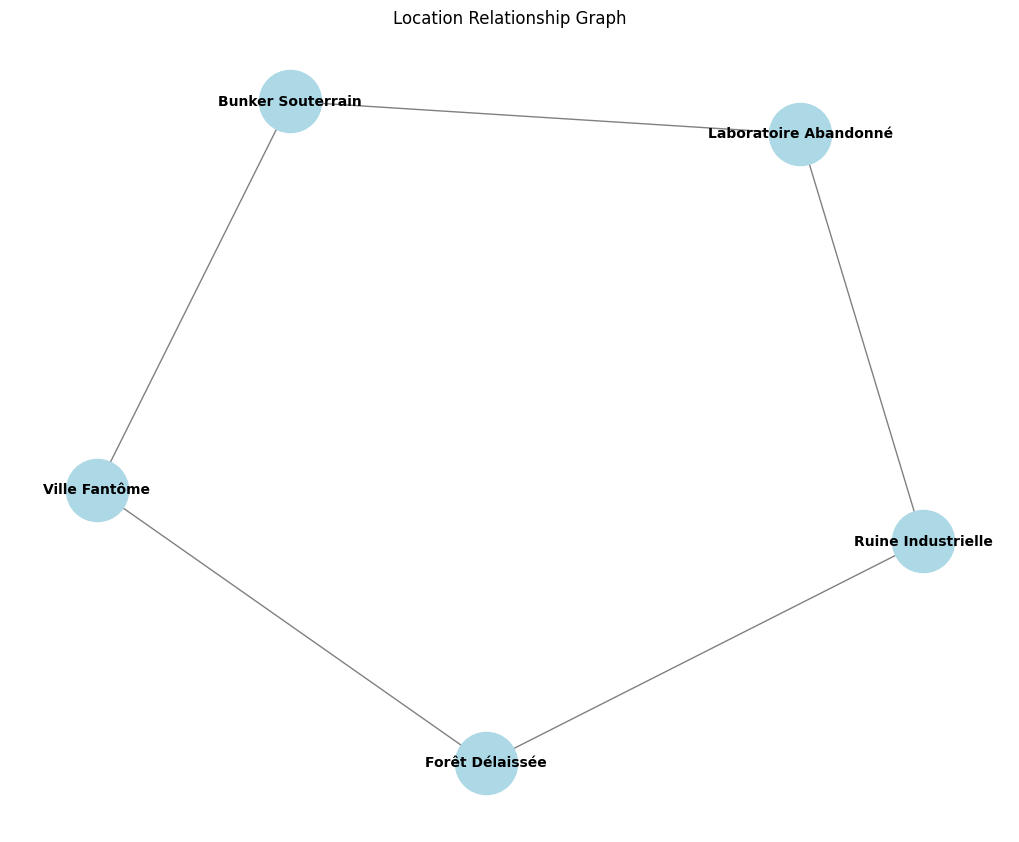

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

def display_location_relationships(locations: onto.Location):
    # Create a graph
    G = nx.Graph()

    # Add nodes and edges
    for location in locations:
        G.add_node(location.hasName)  # Add each location as a node
        for related_location in location.INDIRECT_isLinkedToLocation:
            # Create edges for relationships
            G.add_edge(location.hasName, related_location.hasName)

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # Positioning of the graph

    # Draw nodes, edges, and labels
    nx.draw(G, pos,
            with_labels=True,
            node_color='lightblue',
            node_size=2000,
            font_size=10,
            font_weight='bold',
            edge_color='gray')
    plt.title('Location Relationship Graph')
    plt.show()

with onto:
    display_location_relationships(onto.Location.instances())

Structure works, it's a hub structure with linear branches. This is good enough ! The topology makes sense regarding the relationships of locations.
Extra points for the water structure

## Generate a structured outline of the story from the outline text and generated locations

In [16]:
STORY_OUTLINE_PROMPT = """
# Instructions pour la génération
Vous êtes le scénariste de l'histoire pour une aventure textuelle générative.
Sur la base du contexte narratif et des lieux qui composent le monde ci-dessous, générez les grandes lignes d'une histoire possible en tenant créant les éléments suivants :

    Joueur : Établir la position et le rôle du joueur dans l'histoire, en précisant leur identité, leurs motivations et leur lien avec les personnages principaux. Décrire le point de départ du joueur et son rôle dans le récit global.
    Personnages: Etablir une liste d'au moins **3 à 5** personnages principaux de l'histoire, sans rentrer dans trop de détails mais en évoquant leur fonction narrative et leurs relations (entre eux et avec le joueur). Veille à établir au moins un antagoniste principal.
    Objectif : Définir l'objectif global du joueur, en précisant le problème principal à résoudre ou l'enjeu narratif qui motive l'action.
    Événements : Décrire au moins 1 à 3 événements clés qui alimentent l'histoire et doivent être déclenchés par l'action du joueur.
    Objets : Générer uniquement les éléments essentiels nécessaires pour compléter l'histoire (objets de quête) si c'est mentionné dans le contexte narratif, en incluant : Un nom et une description de chaque objet, avec sa fonction dans le récit. Indiquer le lieu où se trouve chaque objet, en s'assurant qu'il s'intègre logiquement dans le monde.
    Commentaires : Inclure tout commentaire supplémentaire qui pourrait guider la génération de détails supplémentaires ou éclaircir des éléments importants de l'histoire.

# Format de sortie
D'abord, raisonner sur le contexte narratif donné et son importance pour la cohérence du monde et de l'histoire, l'intrigue principale (qui doit être de nature ouverte), et les relations des personnages.
Fournir les éléments dans un fichier json structuré selon le format suivant:
{
    "Player": {
        "name": "Donner le nom du personnage qu'incarne le joueur",
        "description": "Description en quelques phrases du personnage qu'incarne le joueur",
        "location": "Nom du lieu de départ de l'histoire"
    },
    "Characters": [
        {
            "name": "Nom propre du personnage 1",
            "description": "description en une phrase du personnage, incorporant son rôle et sa fonction dans l'histoire, et sa relation aux autres personnages.",
            "location": "Nom du lieu ou se trouve le personnage"
        },
        ...
    ],
    "Goal": {
        "description": "description du problème ou de l'enjeu qui motive le joueur. La résolution du jeu doit rester ouverte"
        "requiresItem": "(FACULTATIF) S'il un objet qui est le centre de l'histoire et doit être récupéré pour gagner, l'indiquer ici. Sinon, omettre ce champs."
    },
    "Events": [
        {
            "name": "Evènement 1",
            "description": "description de l'évènement",
            "condition": "description de la condition qui déclenche l'évènement (devrait être déclenché par l'action du joueur !)",
            "consequence": "Description d'une ou plusieurs conséquences à l'évènement. Ces conséquences doivent être concrètes pour le joueur"
        },
        ...
    ],
    "Items": [
        {
            "name": "Nom de l'objet",
            "description": "description courte de l'objet et de sa fonction dans le récit",
            "location": "(OBLIGATOIRE) Nom du lieu qui contient l'objet"
        },
        ...
    ],
    "Comments": [
        "Tout commentaire que tu voudrais ajouter pour guider la génération de détails supplémentaires et pendant le jeu. Sois précis plus que général: donne des commentaires qui peuvent être exploités. Des éléments importants de l'histoire"
    ]
}

# Lieux du monde
{%- for location in locations %}
- "{{location.hasName}}": {{location.hasDescription}}
  "{{location.hasName}}" mène à {%- for loc in location.INDIRECT_isLinkedToLocation %} "{{loc.hasName}}" {%- endfor %}
{%- endfor %}

# Contexte narratif
{{ setting }}

Rappel: Ne répète pas les lieux du monde. Ton objectif est de développer une histoire qui fonctionne dans ce monde. N'ajoute que des éléments nouveaux dans le JSON. Fournis seulement les informations sur le joueur, son objectif, les personnages principaux, les évènements principaux, les éventuels objets principaux.
Ecris en {{language}}, sauf pour les clés JSON qui doivent rester comme dans l'exemple.

# Résultat
"""

In [17]:
prompt = PromptTemplate(
    template=STORY_OUTLINE_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser()

chain = prompt | model | parser

with onto:
    # print(prompt.invoke({
    #     'setting': outline_text,
    #     'language': language,
    #     'locations': onto.Location.instances()
    # }).text)
    story_outline = chain.invoke({
        'setting': outline_text,
        'language': language,
        'locations': onto.Location.instances()
    })

In [18]:
story_outline

{'Player': {'name': 'Alexandre Durand',
  'description': 'Un ingénieur civil ayant acquis une expertise inattendue dans la survie post-zombie durant les premiers mois de l’épidémie. Motivé par la volonté de restaurer quelque chose de semblable à la vie normale et convaincu qu’un remède existe.',
  'location': 'Ville Fantôme'},
 'Characters': [{'name': 'Marcelle Dupont',
   'description': 'Une médecin chercheuse qui avait travaillé dans le Laboratoire Abandonné. Connaît bien Alexandre et croit en son projet. Se cache dans le Bunker Souterrain.',
   'location': 'Bunker Souterrain'},
  {'name': 'Victor Lafleur',
   'description': 'L’ancien chef de sécurité du Bunker Souterrain. Jaloux des compétences d’Alexandre et sceptique quant à l’utilité de rechercher un remède plutôt que de protéger le groupe existant.',
   'location': 'Bunker Souterrain'},
  {'name': 'Sophia Martin',
   'description': 'Une jeune scientifique qui était étudiante sous Marcelle avant l’invasion. A découvert des indice

Add the new items to the KG

In [19]:
with onto:
    for event_data in story_outline.get('Events'):
        
        event_name = event_data.get('name')
        encoded_event_name = encode_entity_name(event_name)
        
        event = onto.Event(event_name)
        event.hasName = event_name
        event.label = event_name
        event.hasDescription = event_data.get('description')
        event.hasCondition = event_data.get('condition')
        event.hasConsequence = event_data.get('consequence')


In [20]:
with onto:
    for char in story_outline.get('Characters'):
        # First, make sure the location is correct
        loc_name = char.get('location')
        character_location = find_levenshtein_match(loc_name, onto.Location.instances())
        
        if not character_location:
            print(f"Warning: {name}'s location {loc_name} not found in ontology. ")
            continue
        
        # Create new character
        name = char.get('name')
        encoded_name = encode_entity_name(name)
        
        character = onto.Character(encoded_name)

        character.hasName = name
        character.label = name
        character.hasDescription = char.get('description')
        character.hasImportance = 'main character' 
        character.characterIsLocatedAt = character_location


In [21]:
# Problématique, n'est-ce pas ?
print(distance('Centreville Commerciale Abandonnée', 'Centre Commercial Abandonné'))
print(distance('Laboratoire Secret', 'Sanctuaire Secret'))

7
7


In [22]:
# Verify results
with onto:
    #sync_reasoner()
    for loc in onto.Location.instances():
        print(f"{loc.hasName}: {[char.hasName for char in loc.containsCharacter]}")

Ville Fantôme: []
Bunker Souterrain: ['Marcelle Dupont', 'Victor Lafleur']
Forêt Délaissée: []
Laboratoire Abandonné: ['Sophia Martin']
Ruine Industrielle: []


In [23]:
for item_data in story_outline.get('Items'):
    item_name = item_data.get('name')
    encoded_name = encode_entity_name(encoded_name)
    
    item = onto.Item(encoded_name)
    item.hasName = item_name
    item.label = item_name
    item.hasDescription = item_data.get('description')
    item.hasQuantity = item_data.get('quantity', 1)
    item.hasImportance = 'major'
    
    item_location_name = item_data.get('location')
    
    # Find the location among existing locations using fuzzy matching (using Levenshtein distance)
    item_location = find_levenshtein_match(item_location_name, onto.Location.instances())
    
    if not item_location:
        print(f"Warning: item's location {item_location_name} not found in ontology.")
    
    item_location.containsItem.append(item)
    print(item_location.containsItem)
    

[story_ontology3.sophia%2520martin]
[story_ontology3.sophia%2520martin, story_ontology3.sophia%252520martin]


In [24]:
# Verify items
# with onto:
#     sync_reasoner()
#     pass

for item in onto.Item.instances():
    print(f"Name: {item.hasName}")
    print(f"Description: {item.hasDescription}")
    print(f"Importance: {item.hasImportance}")
    print(f"Location: {item.INDIRECT_isLocatedAt.hasName}\n")


Name: Manuscrit Médical
Description: Notes personnelles de Marcelle concernant des traitements possibles.
Importance: major
Location: Laboratoire Abandonné

Name: Équipement Expérimental
Description: Matériel nécessaire pour tester des théories médicales.
Importance: major
Location: Laboratoire Abandonné



In [25]:
# Player
with onto:
    # Create the Player entity
    player_data = story_outline.get('Player')
    player_name = player_data.get('name')
    encoded_name = encode_entity_name(player_name)
    
    player = onto.Player(encoded_name)
    player.hasName = player_name
    player.label = player_name
    player.hasDescription = player_data.get('description')
    player.hasImportance = 'Player'
    
    # Give the player its location
    player_location_name = player_data.get('location')
    
    player_location = find_levenshtein_match(player_location_name, onto.Location.instances())
    
    if player_location:
        player.characterIsLocatedAt = player_location
    else:
        print(f"Warning: {player_name}'s location {player_location_name} not found in ontology. ")
        
    
    # Create the player's Goal entity
    goal_description = story_outline.get('Goal').get('description')
    
    goal = onto.Goal('player_goal')
    goal.label = 'Player goal'
    goal.hasDescription = goal_description
    
    player.hasGoal.append(goal)
    

In [26]:
# Verify the conversion
with onto:
    #sync_reasoner_pellet()

    player = onto.Player.instances()[0]
    print(f"Player: {player.hasName}")
    print(f"Description: {player.hasDescription}")
    print(f"Location: {player.INDIRECT_isLocatedAt.hasName}")
    print(f"Goal: {player.hasGoal[0].hasDescription}")


Player: Alexandre Durand
Description: Un ingénieur civil ayant acquis une expertise inattendue dans la survie post-zombie durant les premiers mois de l’épidémie. Motivé par la volonté de restaurer quelque chose de semblable à la vie normale et convaincu qu’un remède existe.
Location: Ville Fantôme
Goal: Trouver un moyen de mettre fin à l’épidémie zombie afin de permettre aux survivants de reconstruire une société stable et sûre.


In [27]:
CHARACTER_EXPANSION_PROMPT = """
Using the following details, generate a JSON output with additional information about the character.

Character Name: {{character.hasName}}
Description: {{character.hasDescription}}
Starting location: {{character.isLocatedAt.hasName}}

Other main characters of the story:
{%- for char in other_characters %}
    "{{ char.hasName }}": {{ char.hasDescription }} (is located at {{char.INDIRECT_isLocatedAt.hasName}})
{%- endfor %}

The player:
    "{{ player.hasName }}": {{ player.hasDescription }} (is located at {{player.INDIRECT_isLocatedAt.hasName}})
    The player has the goal: {{player.hasGoal[0].hasDescription}}

Please include:
- A significant backstory element that explain their current situation. Improving the character's current description
- One or two relationships that the character has with other main characters or the player.

Ensure that all generated elements align with the narrative and character dynamics already established in the outline.
Output your response in the exact following JSON format:

{
    "description": "The updated, expanded description of the character, defining their goals, motivations, and conflicts, all inside this description string",
    "relationships": [
        {
            "type": "The type of relationship from this character to the target character. Either 'knows', 'friend', 'lover', 'enemy', 'rival', 'subject', 'ruler', no matter the language ",
            "target": "Name of the character which has that relationship with {{character.hasName}}"
        },
        ...
    ]
}

**The relationship types should be chosen EXCLUSIVELY between: 'knows', 'friend', 'lover', 'enemy', 'rival', 'subject', 'ruler', no matter the language !!**

Write all the JSON value strings in {{language}}, except relationship types.
"""

In [28]:

prompt = PromptTemplate(
    template=CHARACTER_EXPANSION_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser()

chain = prompt | model | parser

characters = onto.Character.instances()

# Expand each character's description and relationships
for character in characters:
    if onto.Player in character.is_a:
        continue
    
    print(character.hasName)
    
    # Get the list of other main characters
    other_characters = list()
    for other_character in characters:
        # skip self
        if other_character.hasName == character.hasName:
            continue
        other_characters.append(other_character)
    
    print(character)
    
    # print(prompt.invoke({"setting": outline_text,
    #                     "character": character,
    #                     "player": onto.Player.instances()[0],
    #                     "other_characters": other_characters,
    #                     "language": language}).text)
    # continue

    res = chain.invoke({"setting": outline_text,
                        "character": character,
                        "player": onto.Player.instances()[0],
                        "other_characters": other_characters,
                        "language": language})

    # Update the character in the ontology
    character.hasLongDescription = res.get('description')

    for relationship in res.get('relationships'):
        #'friend', 'lover', 'enemy', 'rival', 'subject', 'ruler'
        relationship_type = relationship.get('type')
        related_character_name = relationship.get('target')
        related_character = find_levenshtein_match(related_character_name, onto.Character.instances())
        
        if not related_character:
            print(f"Warning: {character.hasName}'s relation {related_character_name} not found in ontology.")
            continue
            
        if relationship_type == 'friend':
            character.hasFriendshipWith.append(related_character)
        elif relationship_type == 'lover':
            character.loves.append(related_character)
        elif relationship_type == 'enemy':
            character.isEnemyWith.append(related_character)
        elif relationship_type == 'rival':
            character.hasRivalryWith.append(related_character)
        elif relationship_type == 'subject':
            character.hasAllegiance.append(related_character)
        elif relationship_type == 'ruler':
            character.isRulerOf.append(related_character)
            #related_character.hasAllegiance = [this_character]
        elif relationship_type == 'knows':
            character.knows.append(related_character)

    print('----*----')
    print(res)
    print('\n\n')
    print(f"Name: {character.hasName}")
    print(f"Location: {character.INDIRECT_isLocatedAt.hasName}")
    print(f"Description: {character.hasDescription}")
    print(f"Long description: {character.hasLongDescription}")
    print(f"Friends: {character.INDIRECT_hasFriendshipWith}")
    print(f"Rivals: {character.INDIRECT_hasRivalryWith}")
    print(f"Enemies: {character.INDIRECT_isEnemyWith}")
    print(f"Has allegiance to: {character.INDIRECT_hasAllegiance}")
    print(f"Is ruler of: {character.INDIRECT_isRulerOf}")
    print(f"Loves: {character.INDIRECT_loves}")
    #print(f"Relationships: {character.}")
    print('----*----')

Marcelle Dupont
story_ontology3.marcelle%20dupont
----*----
{'description': "Une médecin chercheuse qui avait travaillé dans le Laboratoire Abandonné où elle cherchait désespérément un remède contre l'épidémie zombie. Elle connaissait bien Alexandre depuis leurs jours au sein d'une équipe de recherche pré-catastrophe. C'est cette relation passée qui lui fait aujourd'hui avoir foi en ses capacités malgré les défiances de certains membres du groupe comme Victor Lafleur. Actuellement cachée dans le Bunker Souterrain, elle espère pouvoir aider Alexandre à trouver ce qui pourrait stopper l'infection.", 'relationships': [{'type': 'friend', 'target': 'Alexandre Durand'}, {'type': 'knows', 'target': 'Sophia Martin'}]}



Name: Marcelle Dupont
Location: Bunker Souterrain
Description: Une médecin chercheuse qui avait travaillé dans le Laboratoire Abandonné. Connaît bien Alexandre et croit en son projet. Se cache dans le Bunker Souterrain.
Long description: Une médecin chercheuse qui avait travai

In [29]:
# Verify consistency and make inferences
# with onto:
#     sync_reasoner()

Great ! We have expanded our characters ! They now have relationships and backstories, this should be interesting !


## Expand Locations

In [30]:
LOCATION_EXPANSION_PROMPT = """
Using the following details, generate a JSON output with additional information about the location.

Setting of the story: {{setting}}

Location Name: {{location.hasName}}
Description: {{location.hasDescription}}
Neighboring locations:
{%- for nearby_location in location.INDIRECT_isLinkedToLocation %}
    - "{{ nearby_location.hasName }}": {{nearby_location.hasDescription}}
{%- endfor %}

{%- if location.containsCharacter %}
Main characters in "{{location.hasName}}":
{%- for character in location.containsCharacter %}
    - "{{ character.hasName }}" {% if onto.Player in character.is_a %}(Player){%- endif %}: {{ character.hasDescription }}
{%- endfor %}
{%- endif %}

{%- if location.containsItem %}
The location contains the quest item(s):
{%- for item in location.containsItem %}
    - "{{ item.hasName }}" ({{item.hasImportance}}): {{ item.hasDescription }}
{%- endfor %}
{%- endif %}

Please DO NOT include this information in your output

Please include:
- Up to two secondary characters that would be relevant to this location. Keep in mind that secondary caracters should have a use to the player, that is either to give the player some important information (define specifically the information), some items, trade or offer a challenge, or other if it is relevant to the scene and the story. You can and should use less, or even no characters, depending on the location ! Only add characters where pertinent.
- Up to two items that could be found or are important in this location. Items should always have a clear use at least in the scene.

Do not call any character these names: {{banned_character_names}}
Do not call any item these names: {{banned_item_names}}
{%- if used_roles %}
Already used secondary character roles (Try not to repeat them too much. Only if it really makes sense): {{used_roles}}
{%- endif %}

Ensure that all generated elements align with the narrative and character dynamics already established in the outline.

Make sure to output the list of characters as JSON, following this exact model:

{
    "Description": "A longer, more detailed description of the location and perhaps its different parts and their function in the story"
    "Characters": [
        {
            "name": "The name of the character",
            "description": "A concise description of the character and their function in the scene.",
            "role": "One or two words describing this character's function"
        },
        ...
    ],
    "Items": [
        {
            "name": "The name of the item",
            "description": "A concise description of the item and its function.",
            "quantity": 1,
        },
        ...
    ]
}

Generate all output in {{ language }}
"""

In [31]:

prompt = PromptTemplate(
    template=LOCATION_EXPANSION_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser()

chain = prompt | model | parser


# banned_character_names = all_character_names
# banned_item_names = all_item_names


for location in onto.Location.instances():
    print(f"Name: {location.hasName}")
    print(location.containsCharacter)

    # Prevent LLM from generating the same items over and over.
    # This improves creativity, and coherence between prompts, since the LLM is
    # at least aware of what kind of items already exist.
    banned_item_names = [i.hasName for i in onto.Item.instances()]
    banned_character_names = [c.hasName for c in onto.Character.instances()]
    used_roles = [c.hasRole for c in onto.Character.instances() if c.hasRole]

    # print(prompt.invoke({"setting": outline_text,
    #                      "onto": onto,
    #                      "location": location,
    #                      "banned_item_names": banned_item_names,
    #                      "banned_character_names": banned_character_names,
    #                      "used_roles": used_roles,
    #                      "language": language}).text)
    # break

    res = chain.invoke({"setting": outline_text,
                        "onto": onto,
                        "location": location,
                        "banned_item_names": banned_item_names,
                        "banned_character_names": banned_character_names,
                        "used_roles": used_roles,
                        "language": language})

    print(res)

    # Update KG with this expanded information
    # Updated long description
    location.hasLongDescription = res.get('Description')
    
    # New secondary Characters
    for char in res.get('Characters'):
        char_name = char.get('name')
        encoded_char_name = encode_entity_name(char_name)
        
        character = onto.Character(encoded_char_name)
        character.hasName = char_name
        character.label = char_name
        character.hasDescription = char.get('description')
        character.hasRole.append(char.get('role')[0])
        character.hasImportance = 'secondary'
        character.characterIsLocatedAt = location
    
    for item_data in res.get('Items'):
        item_name = item_data.get('name')
        encoded_item_name = encode_entity_name(item_name)
        
        item = onto.Item(encoded_item_name)
        item.hasName = item_name
        item.label = item_name
        item.hasDescription = item_data.get('description')
        item.hasImportance = 'minor'
        item.itemIsLocatedAt = location

    print('\n')
    print(f"Location name: {location.hasName}")
    print(f"Description: {location.hasDescription}")
    print(f"Long description: {location.hasLongDescription}")
    print(f"Characters: {location.INDIRECT_containsCharacter}")
    print(f"Items: {location.INDIRECT_containsItem}")
    print('----*----')

Name: Ville Fantôme
[story_ontology3.alexandre%20durand]
{'Description': 'Une ancienne ville maintenant abandonnée où les zombies errent librement. Les immeubles sont partiellement effondrés et les voitures calcinées parsèment les rues. Ce lieu représente un danger permanent mais possède encore des ressources précieuses telles que des médicaments, des armes et de la nourriture. À proximité, la Forêt Délaissée offre un contraste vert et sombre tandis que le Bunker Souterrain promet sécurité et ressources limitées.', 'Characters': [{'name': 'Lucas Valois', 'description': "Un ancien médecin qui a trouvé refuge temporairement dans la Ville Fantôme. Lucas détient des informations cruciales concernant la possible existence d'un laboratoire expérimental localisé près du centre commercial.", 'role': 'Informateur'}], 'Items': [{'name': 'Carte Routière Ancienne', 'description': 'Cette carte montre plusieurs points stratégiques autour de la Ville Fantôme, notamment le chemin vers le Bunker Souter

# Convert informations to knowledge graph

In this step, we convert the JSON-like structured data into entities in an ontology describing the logic of a story world, creating a model for the story we want to generate later.

In [32]:
# with onto:
#     sync_reasoner

In [33]:
with onto:
    for character in onto.Character.instances():
        loc = character.INDIRECT_isLocatedAt

        print(f"{character.hasName} is located at {loc.hasName}")

    
    for location in onto.Location.instances():
        characters = location.INDIRECT_containsCharacter
        print(f"{location.hasName} contains: {characters}")

Marcelle Dupont is located at Bunker Souterrain
Victor Lafleur is located at Bunker Souterrain
Sophia Martin is located at Laboratoire Abandonné
Alexandre Durand is located at Ville Fantôme
Lucas Valois is located at Ville Fantôme
Claire Lambert is located at Bunker Souterrain
Eliane Rousseau is located at Forêt Délaissée
Jean-Pierre Dubois is located at Laboratoire Abandonné
Louis Beaumont is located at Ruine Industrielle
Ville Fantôme contains: [story_ontology3.lucas%20valois, story_ontology3.alexandre%20durand]
Bunker Souterrain contains: [story_ontology3.marcelle%20dupont, story_ontology3.victor%20lafleur, story_ontology3.claire%20lambert]
Forêt Délaissée contains: [story_ontology3.eliane%20rousseau]
Laboratoire Abandonné contains: [story_ontology3.jean-pierre%20dubois, story_ontology3.sophia%20martin]
Ruine Industrielle contains: [story_ontology3.louis%20beaumont]


In [34]:
with onto:
    for character in onto.Character.instances():
        print(f'{character.hasName} friends with: {character.INDIRECT_hasFriendshipWith}')

Marcelle Dupont friends with: [story_ontology3.marcelle%20dupont, story_ontology3.alexandre%20durand]
Victor Lafleur friends with: []
Sophia Martin friends with: []
Alexandre Durand friends with: [story_ontology3.marcelle%20dupont, story_ontology3.alexandre%20durand]
Lucas Valois friends with: []
Claire Lambert friends with: []
Eliane Rousseau friends with: []
Jean-Pierre Dubois friends with: []
Louis Beaumont friends with: []


In [35]:
with onto:
    onto.save(file="story_poptest.rdf", format="rdfxml")

# Pre-generate the first message


In [36]:
FIRST_TURN_PROMPT = """
You are an LLM designed to act as the engine for a text adventure game set in "{{setting}}".

List of the locations that make up this game's world (to give you general context):
{%- for location in locations %}
    - {{ location.hasName }}: {{location.hasDescription}}
{%- endfor %}

The player is located at {{player_start_location_name}}.
The locations accessible from where the player is are {{nearby_locations_names}}

{%- if characters_nearby %}
Characters present in {{location.hasName}}:
{%- for character in characters_nearby %}
    - {{ character.hasName }}: {{character.hasDescription}} (narrative importance {{character.hasImportance}})
{%- endfor %}
{%- else %}
    There are no other characters present in {{location.hasName}}.
{%- endif %}

{%- if items_nearby %}
Items present in {{location.hasName}}:
{%- for item in items_nearby %}
    - {{ item.hasName }}: {{item.hasDescription}} (narrative importance {{item.hasImportance}})
{%- endfor %}
{%- else %}
    There are no items present in {{location.hasName}}.
{%- endif %}

{%- if player.INDIRECT_ownsItem %}
Items in the player's inventory:
{%- for item in player.INDIRECT_ownsItem %}
    - {{ item.hasName }}: {{item.hasDescription}} (narrative importance {{item.hasImportance}})
{%- endfor %}
{%- else %}
    The player has no items in their inventory.
{%- endif %}

You're about to start interacting with the player. The player plays a character in the story:
    "{{player.hasName}}": {{player.hasDescription}}

The player's goal is: {{player.hasGoal[0].hasDescription}}

You need to write an SHORT introduction, explaining where the player is, who they are, and give them a motivation to reach their goal.
Keep in mind that more things can and should be revealed later, after interaction with the player, so feel free to keep some information to yourself for later.
Keep in mind that not everything that is in a location is necessarily immediately visible or known to the player. Things can be hidden within a location, and a location can be quite large.

The game is played by interactions between the game (you) and the player. You will first produce a setting, then the player will type in natural language whatever they want to do, etc.
Do not reveal everything all at once: let the player discover things.
Only output natural text, as one would read in a book they actually were the hero of.
Do not list explicit options, unless the player specifically asks for it.
Do not reveal all the given information at once.

**Your message should be one paragraph at most.**

Your entire output will be visible to the player, so stay in your role of narrator ! All your output should be in {{language}}
"""

In [40]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

prompt = PromptTemplate(
    template=FIRST_TURN_PROMPT,
    template_format='jinja2'
)

with onto:
    player = list(onto.Player.instances())[0]
    current_location = player.INDIRECT_isLocatedAt
    locations = onto.Location.instances()
    characters_nearby = current_location.containsCharacter
    locations_nearby = current_location.isLinkedToLocation
    nearby_locations_names = [l.hasName for l in locations_nearby]
    items_nearby = current_location.containsItem

    # test the prompt generation
    print(prompt.invoke({'setting': setting,
                    'locations': locations,
                    'location': current_location,
                    'characters_nearby': characters_nearby,
                    'items_nearby': items_nearby,
                    'player': player,
                    'player_start_location_name': current_location.hasName,
                    'nearby_locations_names': nearby_locations_names,
                    'language': language}).text)

chain = prompt | model
adventure_start = chain.invoke({'setting': setting,
                    'locations': locations,
                    'location': current_location,
                    'characters_nearby': characters_nearby,
                    'items_nearby': items_nearby,
                    'player': player,
                    'player_start_location_name': current_location.hasName,
                    'nearby_locations_names': nearby_locations_names,
                    'language': language})



You are an LLM designed to act as the engine for a text adventure game set in "post-apocalypse zombie mondiale, 1 an après le début de l'épidémie".

List of the locations that make up this game's world (to give you general context):
    - Ville Fantôme: Une ancienne ville maintenant abandonnée où les zombies errent librement. Les immeubles sont partiellement effondrés et les voitures calcinées parsèment les rues. C'est ici que commence notre histoire, endroit dangereux mais potentiellement rempli de ressources utiles.
    - Bunker Souterrain: Un bunker militaire secret construit avant même la catastrophe. Il abrite actuellement une petite communauté de survivants qui ont réussi à y entrer juste avant sa fermeture automatique. L'eau potable et la nourriture sont limitées, mais il offre une protection contre les attaques extérieures.
    - Forêt Délaissée: Cette zone boisée entoure presque toute la Ville Fantôme. Bien que moins peuplée de zombies, elle recèle également des dangers tels 

In [41]:
print(adventure_start.content)

Tu te trouves au cœur de ce qui était autrefois une ville prospère, aujourd'hui réduite à un chaos silencieux appelé Ville Fantôme. Autour de toi, les bâtiments délabrés témoignent d’une époque passée tandis que les ombres mouvantes des zombies hantent chaque coin sombre. Tu es Alexandre Durand, un ingénieur civil transformé en survivant aguerri depuis le début de cette pandémie terrifiante. Ta conviction reste intacte : trouver un moyen de stopper définitivement ces créatures infectées est non seulement ta mission personnelle, mais aussi celle de tous ceux qui espèrent voir renaître une forme quelconque de normalité. La route sera longue et périlleuse, mais tu sais désormais que chaque détail peut faire la différence entre la survie et l’extinction. Que décides-tu de faire ?
